Project Analysis

In [1]:
import pandas, numpy
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb

In [2]:
training_set = pandas.read_csv("../processed_data/training_set.csv")
testing_set = pandas.read_csv("../processed_data/testing_set.csv")

print(len(training_set), len(testing_set))


15786 12916


In [3]:
for dataset in [training_set, testing_set]:
    dataset.drop(columns=['Unnamed: 0'], inplace=True)

In [4]:
training_set

,annual_income,education_category,living_place,family_size,age,working_years,employed,emp_stability,has_children,owns_realty_and_car,has_contact_information,credit_window,bad_client
0,220500,3.0,3,1.0,47,1,True,False,False,False,True,10,False
1,360000,3.0,3,2.0,34,11,True,True,False,False,False,35,False
2,202500,2.0,3,2.0,43,11,True,True,False,True,True,38,False
3,135000,3.0,3,3.0,46,3,True,False,True,False,False,5,False
4,135000,3.0,3,2.0,46,15,True,True,False,False,True,39,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15781,157500,3.0,3,2.0,39,12,True,True,False,False,True,29,False
15782,135000,3.0,3,3.0,30,2,True,False,True,True,False,36,False
15783,247500,1.0,3,3.0,42,2,True,False,True,True,True,37,False
15784,135000,2.0,3,1.0,48,0,True,False,False,False,False,55,False


In [5]:
testing_set['bad_client'].value_counts()

bad_client
False    12784
True       132
Name: count, dtype: int64

Correlation between features

<Axes: >

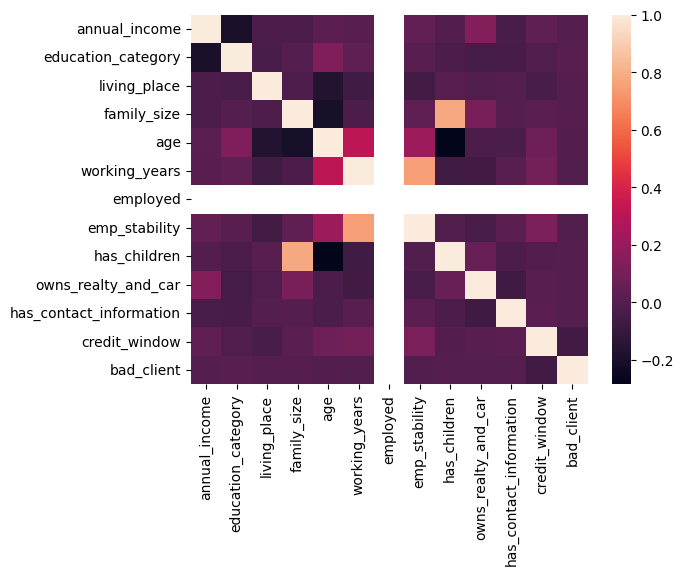

In [6]:
sns.heatmap(training_set.corr())

Initializing XG Boost Classifier

In [7]:
xg_model = xgb.XGBClassifier()

Hyperparameter Tuning for XGBoost Model using GridSearchCV on training set (imbalanced)

In [8]:
x_training, y_training = training_set.drop(columns=['bad_client']), training_set['bad_client']

In [ ]:
# Selecting models and apply hyperparameter tuning
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import make_scorer, precision_recall_curve
from scipy import integrate
import numpy

def calculate_auc_pr_score(y_true, y_pred):
    """
    Function calculates auc pr score, based on ROC-AUC
    """
    precisions, recalls, _ = precision_recall_curve(y_true, y_pred)
    sorted_index = numpy.argsort(precisions)
    precisions = numpy.array(precisions)[sorted_index]
    recalls = numpy.array(recalls)[sorted_index]
    return integrate.trapz(x=precisions, y=recalls)
    
score_function = make_scorer(calculate_auc_pr_score)

# First Round 
xg_hyperparams = {
    'min_child_weight': [1, 5, 10],
    'gamma': [0, 0.25, 0.5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.5, 0.6, 1.0],
    'max_depth': [3, 4, 5]
}

new_cvs = GridSearchCV( 
    estimator=xg_model,
    param_grid=xg_hyperparams,
    scoring=score_function,
    cv=StratifiedKFold(n_splits=10),
    error_score="raise",
    n_jobs=-1,
)


print('fitting xgboost model....')
new_cvs.fit(x_training, y_training)

# the lower loss score is, the better model performs 

print('selecing optimal parameters...')
optimal_params = new_cvs.best_params_

opt_model = xgb.XGBClassifier(**optimal_params)

fitting xgboost model....


In [ ]:
print('auc pr score for hp tuning - ', new_cvs.best_score_)

Feature Selection using RFE (Recursive Feature Elimination) using validation set

In [ ]:
# from sklearn.feature_selection import RFECV

# x_validation = validation_set.drop(columns=['bad_client'])
# y_validation = validation_set['bad_client']

# # feature selector
# estimator = RFECV(
#     estimator=opt_model, 
#     step=2, min_features_to_select=5,
#     cv=StratifiedKFold(n_splits=5),
#     scoring=['accuracy', 'f1_score'],
# )

# # fitting the model 
# estimator.fit(x_validation, y_validation)
    
# features_idxs = list(
#     filter(
#         lambda feature: estimator.support_[feature] == True,
#         range(len(x_validation.columns))
#     )
# )

# feature_func = (lambda feature: training_set[0].columns[feature])

# res = {
#     'features': feature_func(features_idxs),
#     'metrics': numpy.mean(estimator.cv_results_['mean_test_score'])    
# }
# res

# important_features = res['features']

# print(important_features)

Splitting important data for testing set

In [ ]:
# testing_set = testing_set[important_features]

Cross-validating model on testing set

In [ ]:
from sklearn.model_selection import cross_validate 

x_testing, y_testing = testing_set.drop(columns=['bad_client']), testing_set['bad_client']

scores = cross_validate(
    estimator=opt_model,
    X=x_testing,
    y=y_testing,
    scoring=score_function,
)
print('auc-pr score (for cross-validation) - ', numpy.mean(scores['test_score']))

Saving model object to the Pickle file

In [ ]:
# saving machine learning model using pickle 
import pickle 
pickle.dump(opt_model, open("classifier.pkl", mode="wb"))